In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [1]:
suptitles = {a+topo : a+", "+{'_2pi':r"$\pi\pi$", '_pi_p':r"$\pi p$"}[topo] for a in 'D C Fe Pb'.split() for topo in '_2pi _pi_p'.split()}

In [2]:
# from __future__ import absolute_import, division, print_function
# from matplotlib import pyplot as plt
# from matplotlib.patches import Patch
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# import tensorflow.keras
# import tensorflow.keras.backend as K
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import EarlyStopping
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [22]:
import time
import numpy as np
import pandas as pd
#import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
#from root_pandas import read_root
from matplotlib import rc
from numpy import inf


import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
#import ROOT
#from ROOT import TFile

#import root_pandas
%matplotlib inline

import uproot

rc('text', usetex=True)

import matplotlib as mpl
#rc('font', family='serif')
#rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [23]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

#rc('font', family='serif')
#rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [24]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [25]:
# Check Versions
#print(tf.__version__)  # 1.15.0
#print(tensorflow.keras.__version__)  # 2.2.4

!pip install "pandas<2.0.0"

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Obtain datasets and simulations

In [72]:
def getdataFromPkl(filename,treename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)[treename]


dfs_all={}
dfs_all['D']=pd.concat([getdataFromPkl(f"data_pion_proton_pairs_{target}.pkl", 'D_%s'%target) for target in "C Fe Pb".split()])
for target in "C".split():
    dfs_all[target]=getdataFromPkl(f"data_pion_proton_pairs_{target}.pkl", '%s'%target)

for target in 'D'.split():
    dfs_all[f'MC_{target}'] = getdataFromPkl(f"MC_pion_proton_pairs_{target}.pkl", target)

dfs_all[f'MC_solid']=pd.concat([getdataFromPkl(f"MC_pion_proton_pairs_{target}.pkl", target) for target in "C".split()])
for a in dfs_all:
    print(a);print(len(dfs_all[a]))

D
154574
C
46028
MC_D
1001048
MC_solid
3427848


In [73]:
import R2h_module

for key in list(dfs_all.keys()):
    if '_2pi' in key or '_pi_p' in key or '_trigger' in key:
        continue
    df = dfs_all[key]
    df.eval('inelasticity = nu/5.014', inplace=True)
    df.eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
    df.eval('pi='+str(np.pi),inplace=True) #not sure why eval doesn't know what pi is.  
    df.eval('diff_phi_cm = 2*pi*(diff_phi_cm<-pi)-2*pi*(diff_phi_cm>pi)')
    df.eval('h1_e = h1_z*nu', inplace=True)
    df.eval('h2_e = h2_z*nu', inplace=True)
    df.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    df.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    df.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    df.eval('diff_rap_cm = drap',inplace=True)
    print(df.columns)
    if "MC" not in key:
        dfs_all[key+"_pi_p"] = R2h_module.applyCuts(R2h_module.applyCutsPair(df,h2Proton=True)).query("h1_pid==211 and h2_pid==2212")
    else :
        #dfs_all[key+"_pi_p"] = R2h_module.applyCuts(df).query("h1_truth_pid==211 and h2_truth_pid==2212")
        dfs_all[key+"_pi_p"] = R2h_module.applyCuts(df).query("h1_pid==211 and h2_truth_pid==2212")
    

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'e_px', 'e_py',
       'e_pz', 'e_p', 'e_ph', 'e_th', 'SampFracEl25', 'SampFracEl20',
       'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th',
       'h1_p', 'h2_p', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe',
       'h1_Sector', 'h2_Sector', 'h1_FidCut', 'h2_FidCut', 'h1_FidCutPiPlus',
       'h2_FidCutPiPlus', 'h1_Chi2CC', 'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC',
       'h1_Betta', 'h2_Betta', 'h1_T4', 'h2_T4', 'evnt', 'run', 'inelasticity',
       'diff_phi_cm', 'pi', 'h1_e', 'h2_e', 'h2_mass', 'diff_rap_cm'],
      dtype='object')
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 154574  (100.00  %)
2.2 < nu < 4.2 148808  (96.27  %)
secondary hadrons are proto

In [74]:
# for key in list(dfs_all.keys()):
#     if '_trigger' not in key or "_cut" in key:
#         continue
#     df = dfs_all[key]
#     print(df.columns)
#     df.eval('inelasticity = nu/5.014', inplace=True)
#     df.eval('pi='+str(np.pi),inplace=True) #not sure why eval doesn't know what pi is. 
#     df.eval('h1_e = h1_z*nu', inplace=True)
#     df.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
#     print(df.columns)
#     dfs_all[key+"_cut"] = R2h_module.applyCuts(df)
# for key in list(dfs_mixed.keys()): 
#     if '_2pi' in key or '_pi_p' in key:
#         continue
#     print('key is ',key)
#     dfs_mixed[key+"_2pi"] = applyCuts(applyCutsPair(dfs_mixed[key],dipion=True))
#     dfs_mixed[key+"_pi_p"] = applyCuts(applyCutsPair(dfs_mixed[key],pi_p=True))
# for key in list(dfs_trigger.keys()):
#     if '_2pi' in key or '_pi_p' in key:
#         continue
#     dfs_trigger[key] = applyCuts(dfs_trigger[key])

In [75]:
dfs_all.keys()
dfs_all={a:dfs_all[a] for a in ("MC_solid_pi_p","MC_D_pi_p", "C_pi_p", "D_pi_p")}

In [76]:
for key in dfs_all.keys():
    df = dfs_all[key]
    if not "_trigger" in key:
        df['pass_reco'] = np.where((df['h1_cm_pt']>0) & (df['h2_cm_pt']>0)& (df['Q2']>0), 1, 0)
    else :
        df['pass_reco'] = np.where((df['h1_cm_pt']>0)&(df['Q2']>0), 1, 0) 
    if 'h2_truth_cm_pt' in df.columns:
        df['pass_truth'] = np.where((df['h2_truth_cm_pt']>0) & (df['Q2_truth']>0) & (df['h1_truth_cm_pt']>0), 1, 0)
    else:
        df['pass_truth'] = np.where(df['Q2']>0, 1, 0)


#mc_hadron['pass_reco'] = np.where(mc_hadron['h_cm_pt']>0, 1, 0)
#mc_hadron['pass_truth'] = np.where(mc_hadron['h_truth_cm_pt']*mc_hadron['Q2']>0, 1, 0)
#data_hadron['pass_reco'] = np.where(data_hadron['h_cm_pt']>0, 1, 0)

In [77]:
#patch the things that are zero
for df in dfs_all.values():
    for column in df.columns:
        if "truth" in column and (not "pass" in column) and column != "E":
            df[column] = df[column]*df.pass_truth+(1-df.pass_truth)*-9999
        if not "truth" in column and (not "pass" in column) and column != "E":
            df[column] = df[column]*df.pass_reco+(1-df.pass_reco)*-9999



In [78]:

print(dfs_all.keys())
q_mc={"_2pi":"h1_truth_pid*h2_truth_pid==-211**2", 
      "_pi_p":"abs(h1_truth_pid)==211 and h2_truth_pid==2212", 
      "_trigger_cut": "abs(h1_truth_pid)==211 and h1_truth_z>0.5"}
dfs_data = {a+topo : dfs_all[a+topo] for a in 'D C'.split() for topo in '_pi_p'.split()}
#dfs_mc = {a+topo : dfs_all['MC_' + a+topo] for a in 'D C Fe Pb'.split() for topo in '_pi_p'.split()}

dfs_mc = {"D_pi_p" : dfs_all['MC_D_pi_p'],"C_pi_p" : dfs_all['MC_solid_pi_p']}

dict_keys(['MC_solid_pi_p', 'MC_D_pi_p', 'C_pi_p', 'D_pi_p'])


## You want reasonable sample of MC,
## Try at minimum e.g x 3 the data size

In [79]:

for key in dfs_data.keys():
    print(key, len(dfs_data[key]), len(dfs_mc[key]), len(dfs_mc[key])*1./len(dfs_data[key]))
    trimlength = int(len(dfs_mc[key])/3)
    dfs_data[key] = dfs_data[key][:trimlength]
#print(len(data))
#print(len(mc.query('pass_reco==1'))) ##only what is really reconstructed counts
#print(len(mc)) ##only what is really reconstructed counts

D_pi_p 148808 143494 0.9642895543250363
C_pi_p 44044 483923 10.987262737262737


## Unfold Data

In [80]:
# import omnifold

# dfs_data = dict(dfs_data)
# dfs_mc = dict(dfs_mc)

# name="C_pi_p"

# variables = 'h1_cm_ph h2_cm_ph h1_z h2_z x Q2 h1_cm_pt h2_cm_pt'.split()
# variables_truth = 'h1_truth_cm_ph h2_truth_cm_ph h1_truth_z h2_truth_z x_truth Q2_truth h1_truth_cm_pt h2_truth_cm_pt'.split()

# print(len(dfs_mc[name][variables[0]]))


# vs=[list(dfs_mc[name][v]) for v in variables]
# MC_reco=np.transpose(vs)

# vs=[list(dfs_mc[name][v])for v in variables_truth]
# MC_gen=np.transpose(vs)
# pass_reco_mask=list(dfs_mc[name]["pass_reco"])

# vs=[list(dfs_data[name][v]) for v in variables]
# data_reco=np.transpose(vs)
# pass_reco_data=[1 for event in range(len(dfs_data[name]))]

# MC_dataloader = omnifold.DataLoader(reco = MC_reco,
#                            gen = MC_gen,
#                            pass_reco = pass_reco_mask,
#                            normalize = True)

# data_dataloader = omnifold.DataLoader(reco = data_reco,
#                              pass_reco = pass_reco_data,
#                              normalize = True)
# ndim = len(variables) #The number of features present in your dataset
# reco_model = omnifold.MLP(ndim)
# gen_model = omnifold.MLP(ndim)
# omnifold_dnn = omnifold.MultiFold(
#     "BDT Omnifold paper",
#     reco_model,
#     gen_model,
#     data_dataloader, # a dataloader instance containing the measured data
#     MC_dataloader # a dataloader instance containing the simulation
# )
# start_time = time.time()
# omnifold_dnn.Unfold()
# omnifold_dnn_weights = omnifold_dnn.weights_push
# end_time = time.time()
# dnn_unbinned_multi_time = end_time-start_time
# print(f"Total time {end_time-start_time}")

In [87]:
from omnifold_bdt import unbinned_omnifold

dfs_data = dict(dfs_data)
dfs_mc = dict(dfs_mc)
weights={}
for name in "D_pi_p", "C_pi_p":
    
    
    variables = 'h1_cm_ph h2_cm_ph h1_z h2_z x Q2 h1_cm_pt h2_cm_pt'.split()
    variables_truth = 'h1_truth_cm_ph h2_truth_cm_ph h1_truth_z h2_truth_z x_truth Q2_truth h1_truth_cm_pt h2_truth_cm_pt'.split()
    
    print(len(dfs_mc[name][variables[0]]))
    
    
    vs=[list(dfs_mc[name][v]) for v in variables]
    MC_reco=np.transpose(vs)
    
    vs=[list(dfs_mc[name][v])for v in variables_truth]
    MC_gen=np.transpose(vs)
    pass_reco_mask=np.asarray(dfs_mc[name]["pass_reco"]==1)
    pass_truth_mask=np.asarray(dfs_mc[name]["pass_truth"]==1)
    
    vs=[list(dfs_data[name][v]) for v in variables]
    data_reco=np.transpose(vs)
    pass_reco_data=[1 for event in range(len(dfs_data[name]))]
    
    itnum=3
    nan_mask = ~np.isnan(MC_gen)
    nan_mask=[not (False in nan_mask[i]) for i in range(len(nan_mask))]
    #print(len(pass_reco_mask), 
    #nan_mask_flat=nan_mask.

    print(np.sum(1*(nan_mask==False)))

    weights[name] = unbinned_omnifold(
        MC_gen[nan_mask], 
        MC_reco[nan_mask], 
        data_reco,
        pass_reco_mask[nan_mask], 
        pass_truth_mask[nan_mask],
        itnum,
        train_test_split = False)
print('done')

143494
0
[1. 1. 1. ... 1. 1. 1.]
Starting iteration 0
Starting iteration 1
Starting iteration 2
483923
0
[1. 1. 1. ... 1. 1. 1.]
Starting iteration 0
Starting iteration 1
Starting iteration 2
done


In [88]:
weights['C_pi_p']

array([[[4.45882141e-04, 8.58242093e-04, 5.36346642e-02, ...,
         1.48489349e-01, 8.68499915e-02, 5.55172364e-02],
        [2.66098792e-02, 1.09844915e-01, 5.23643098e-02, ...,
         1.37937453e-01, 5.76586061e-02, 4.04219573e-02]],

       [[1.40751241e-04, 1.42293378e-03, 7.09656023e-02, ...,
         7.82953608e-02, 7.89431462e-02, 7.03509867e-02],
        [2.20399220e-02, 8.66720960e-02, 5.24326339e-02, ...,
         1.01396756e-01, 4.74084823e-02, 3.16642250e-02]],

       [[1.22139082e-04, 8.76396663e-04, 8.67277617e-02, ...,
         8.56721750e-02, 8.41593487e-02, 4.49515291e-02],
        [2.23769655e-02, 9.28611999e-02, 5.62654118e-02, ...,
         9.36818618e-02, 4.56344273e-02, 2.91015738e-02]]])

In [54]:
# from omnifold_bdt import unbinned_omnifold

# dfs_data = dict(dfs_data)
# dfs_mc = dict(dfs_mc)

# name="C_pi_p"

# variables = 'h1_cm_ph'.split()# h2_cm_ph h1_z h2_z x Q2 h1_cm_pt h2_cm_pt'.split()
# variables_truth = 'h1_truth_cm_ph'.split()# h2_truth_cm_ph h1_truth_z h2_truth_z x_truth Q2_truth h1_truth_cm_pt h2_truth_cm_pt'.split()

# print(len(dfs_mc[name][variables[0]]))


# vs=[list(dfs_mc[name][v]) for v in variables]
# MC_reco=np.transpose(vs)

# vs=[list(dfs_mc[name][v])for v in variables_truth]
# MC_gen=np.transpose(vs)
# pass_reco_mask=np.asarray(dfs_mc[name]["pass_reco"]==1)
# #print(pass_reco_mask[:1000])
# pass_truth_mask=np.asarray(dfs_mc[name]["pass_truth"]==1)
# #print(pass_truth_mask[:1000])

# vs=[list(dfs_data[name][v]) for v in variables]
# data_reco=np.transpose(vs)
# pass_reco_data=[1 for event in range(len(dfs_data[name]))]

# itnum=2

# weights, MC_test, sim_test, pass_reco_test = unbinned_omnifold(
#     MC_gen[:100000], 
#     MC_reco[:100000], 
#     data_reco[:20000],
#     pass_reco_mask[:100000], 
#     pass_truth_mask[:100000],
#     itnum)
# print('done')

1302601
Starting iteration 0
Starting iteration 1
done


In [17]:
set(weights[-1,0])

{0.04277283508596952,
 0.04397734950423171,
 0.04032109669718409,
 0.03167850114547832,
 0.028182258256109094,
 0.03532348296658938,
 0.07092190185912273,
 0.027148322616383783,
 0.022499716578934684,
 0.028617574958204276,
 0.0437734762546711,
 0.03521645739229485,
 0.03394774978281135,
 0.03426507912367072,
 0.04075108706376796,
 0.035208032677346075,
 0.026436802568781566,
 0.037016625121708564,
 0.03097387171881395,
 0.042521606979377694,
 0.03766367248741177,
 0.03468137623393376,
 0.04090215098071327,
 0.03779269486199156,
 0.03377551545509051,
 0.032686680025008755,
 0.05698840933639816,
 0.029652272600856143,
 0.04432399220084451,
 0.03587610281850575,
 0.03526784533107732,
 0.04484843683660247,
 0.03738493057969097,
 0.04329779462347008,
 0.035046363868360714,
 0.041569361946869804,
 0.03346650461246273,
 0.0405281889867837,
 0.04626592397707444,
 0.04146312954924273,
 0.030548197322829686,
 0.029126890322885436,
 0.026799692946838184,
 0.03601263300558347,
 0.0371710794476456

In [89]:
for key in weights.keys():
    print(key, len(dfs_mc[key]), len(weights[key][-1,0,:]))
    for i in range(len(weights[key])):
        dfs_mc[key][f'weight_reco_{i}'] = weights[key][i, 0, :]
        dfs_mc[key][f'weight_truth_{i}'] = weights[key][i, 1, :]

D_pi_p 143494 143494
C_pi_p 483923 483923


/tmp/ipykernel_734100/467964037.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(bin_centers, (n_pass/n_tot), color='k' if a == 'D' else None,label=a)
/tmp/ipykernel_734100/467964037.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(bin_centers, (n_pass/n_tot), color='k' if a == 'D' else None,label=a)
/tmp/ipykernel_734100/467964037.py:32: RuntimeWarning: invalid value encountered in divide
  y = (n_pass/n_tot)/(n_pass_D/n_tot_D)
/tmp/ipykernel_734100/467964037.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(bin_centers, (n_pass/n_tot), color='k' if a == 'D' else None,label=a)
/tmp/ipykernel_734100/467964037.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(bin_centers, (n_pass/n_tot), color='k' if a == 'D' else None,label=a)
/tmp/ipykernel_734100/467964037.py:32: RuntimeWarning: invalid value encountered in divide
  y = (n_pass/n_tot)/(n_pass_D/n_tot_D)


nan


/tmp/ipykernel_734100/467964037.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(bin_centers, (n_pass/n_tot), color='k' if a == 'D' else None,label=a)
/tmp/ipykernel_734100/467964037.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(bin_centers, (n_pass/n_tot), color='k' if a == 'D' else None,label=a)
/tmp/ipykernel_734100/467964037.py:32: RuntimeWarning: invalid value encountered in divide
  y = (n_pass/n_tot)/(n_pass_D/n_tot_D)
/tmp/ipykernel_734100/467964037.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(bin_centers, (n_pass/n_tot), color='k' if a == 'D' else None,label=a)
/tmp/ipykernel_734100/467964037.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(bin_centers, (n_pass/n_tot), color='k' if a == 'D' else None,label=a)
/tmp/ipykernel_734100/467964037.py:32: RuntimeWarning: invalid value encountered in divide
  y = (n_pass/n_tot)/(n_pass_D/n_tot_D)


nan


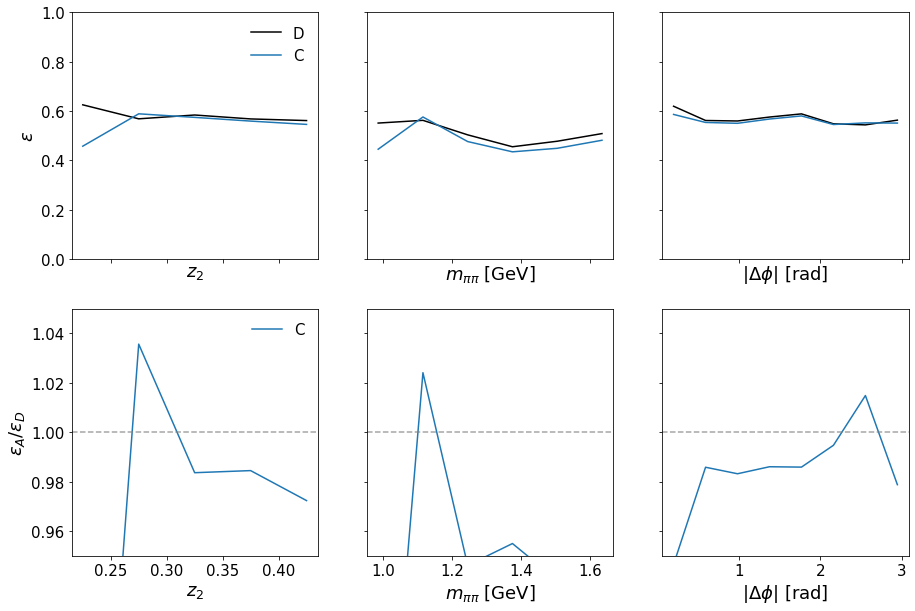

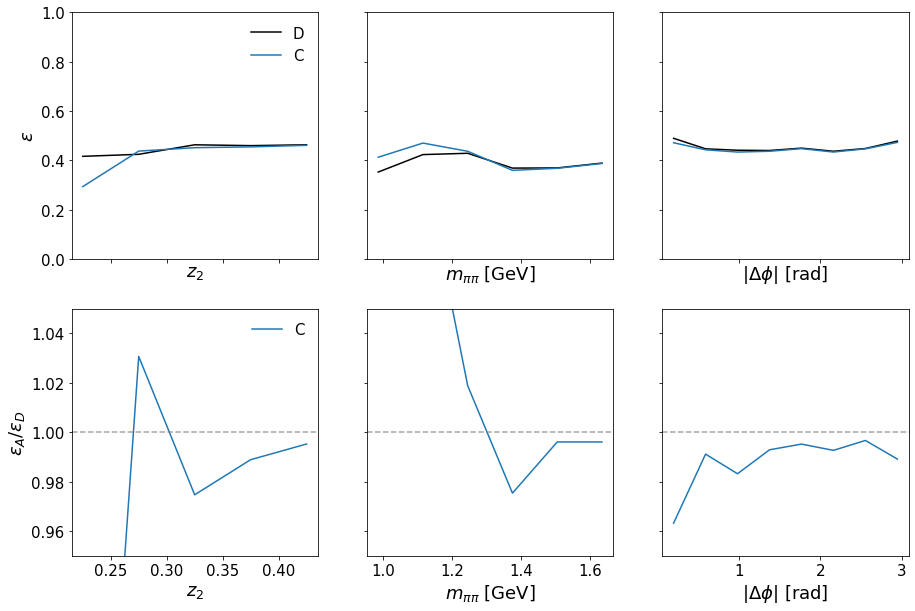

In [84]:
for w in [True, False]:
    fig, axs= plt.subplots(2,3, figsize=(15,10),sharey='row', sharex='col')
    sumsq = 0
    for i,(bins, xvar_truth) in enumerate([(np.linspace(0.05,.45,9),'h2_truth_z'),
                            (np.linspace(0.4,1.7,11),'pair_mass_truth'),
                            (np.linspace(0,np.pi,9),'dphi_truth')]):
        for a in "D C".split():

            df = dfs_mc[f'{a}_pi_p']#.query("weight_truth>0")
            w_default = np.mean(df.query("pass_recon==1").weight_truth)
            if w:
                weight=f"weight_truth*pass_reco+(pass_reco!=0)*{w_default}"
                weight=f"weight_truth"
            else :
                weight = "Q2/Q2"
            n_pass,x = np.histogram(df.query("pass_recon==1")[xvar_truth],
                                    weights=df.query("pass_recon==1").eval(weight),
                                    bins=bins)
            n_tot,x = np.histogram(df[xvar_truth], 
                                    weights=df.eval(weight),
                                    bins=bins)
            bin_centers = 0.5*(x[1:]+x[:-1])

            plt.sca(axs[0][i]) 
            plt.plot(bin_centers, (n_pass/n_tot), color='k' if a == 'D' else None,label=a)
            if(a=='D'):
                n_pass_D = n_pass
                n_tot_D = n_tot

            else :
                plt.sca(axs[1][i]) 
                y = (n_pass/n_tot)/(n_pass_D/n_tot_D)
                sumsq +=sum((y-1)**2)
                plt.plot(bin_centers, y,label=a)
        axs[1][i].axhline(1, color='0.5', alpha=0.7, linestyle='--')
    axs[0][0].legend()
    axs[0][0].set_ylabel("$\epsilon$")
    axs[1][0].legend()
    axs[1][0].set_ylabel("$\epsilon_A/\epsilon_D$")
    
    axs[0][0].set_xlabel("$z_2$")
    axs[0][1].set_xlabel("$m_{\pi\pi}$ [GeV]")
    axs[0][2].set_xlabel("$|\Delta\phi|$ [rad]")
    axs[1][0].set_xlabel("$z_2$")
    axs[1][1].set_xlabel("$m_{\pi\pi}$ [GeV]")
    axs[1][2].set_xlabel("$|\Delta\phi|$ [rad]")
    axs[0][0].set_ylim(0,1)
    axs[1][0].set_ylim(0.95,1.05)
    print(np.sqrt(sumsq/26))
    if w :
        plt.savefig("images/efficiency_weighted.png")
    else :
        plt.savefig("images/efficiency_unweighted.png")
    

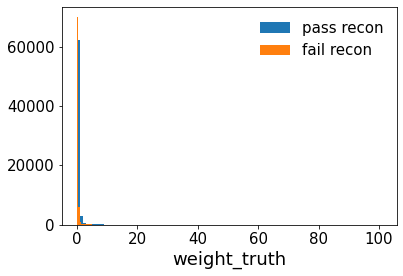

In [123]:
plt.hist(dfs_mc['D_pi_p'].query("pass_recon==1").weight_truth,bins=100, label="pass recon")
plt.hist(dfs_mc['D_pi_p'].query("pass_recon!=1").weight_truth,bins=100, label="fail recon")
plt.gca().set_xlabel("weight_truth")
plt.gca().legend()
plt.show()

In [124]:
#list all data in history
# summarize history for accuracy

def make_history_plots(key):
    history = histories[key]
    for i in range(4):
        fig,ax = plt.subplots(1,2,figsize=(16,6))
        ax[0].set_title('Step 1: \nreweight sim. from data')
        ax[0].set_xlabel('epoch number')
        ax[0].plot(history['step1'][i].history['loss'][1:],'o',label='Step 1 train loss')
        ax[0].plot(history['step1'][i].history['val_loss'][1:],'o',label='Step 1 test loss')
        ax[0].legend()

        #ax[1].set_title('model accuracy')
        #ax[1].plot(history['step1'][i].history['accuracy'][1:],'o',label='Step 1 train')
        #ax[1].plot(history['step1'][i].history['val_accuracy'][1:],'o',label='Step 1 test')
        #ax[1].legend()
        #ax[1].set_xlabel('epoch number')

        ax[1].set_title('Step 2: \nreweight gen. from sim.')
        ax[1].set_xlabel('epoch number')
        ax[1].plot(history['step2'][i].history['loss'][1:],'o',label='Step 2 train loss')
        ax[1].plot(history['step2'][i].history['val_loss'][1:],'o',label='Step 2 test loss')
        ax[1].legend()

        #ax[3].set_title('model accuracy')
        #ax[3].plot(history['step2'][i].history['accuracy'][1:],'o',label='Step 2 train')
        #ax[3].plot(history['step2'][i].history['val_accuracy'][1:],'o',label='Step 2 test')
        #ax[3].legend()
        #ax[3].set_xlabel('epoch number')

        #for a in ax:
        #    a.set_ylim(0)
        plt.savefig(f"images/reweight_history_iter_{i}_{key}.png",bbox_inches='tight')

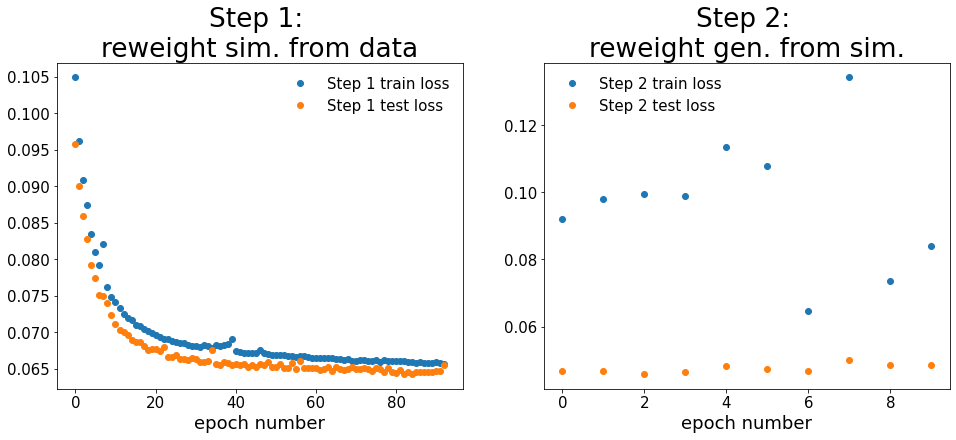

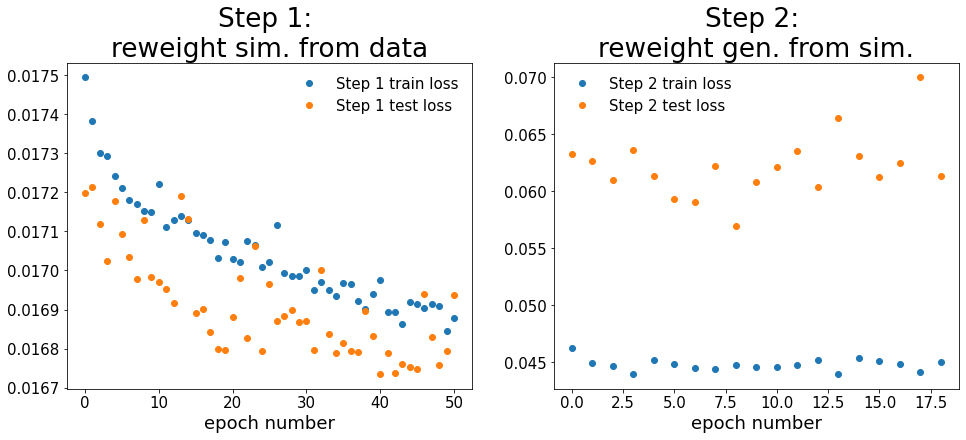

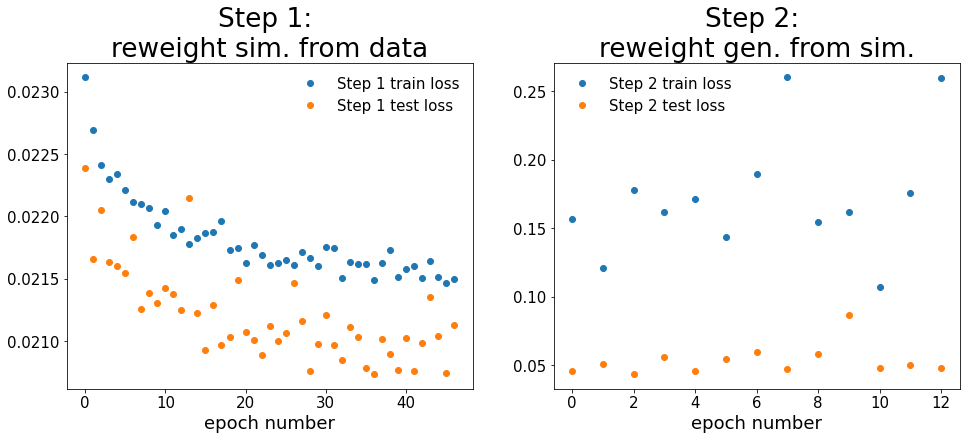

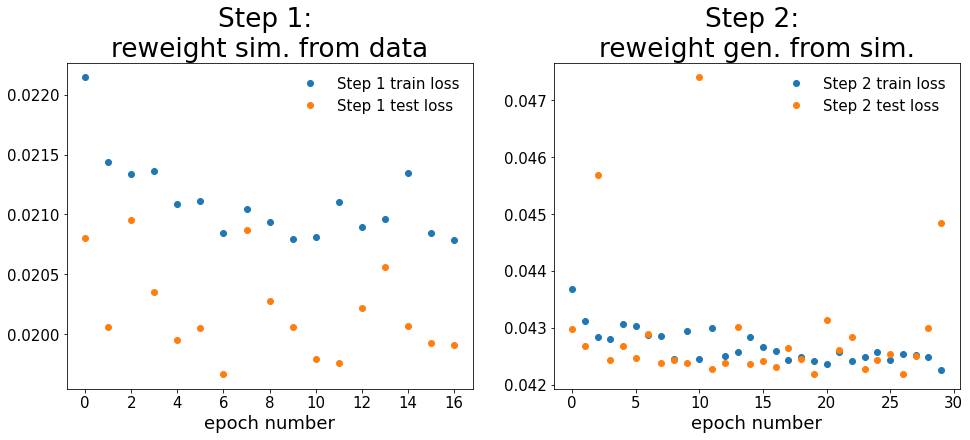

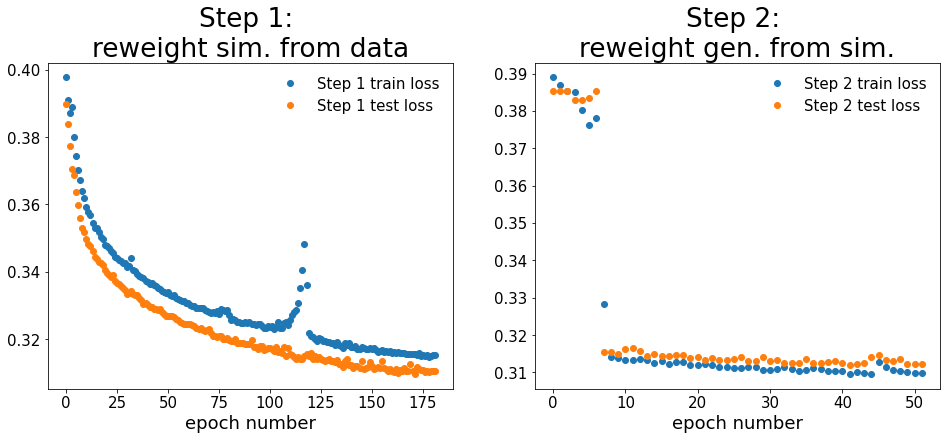

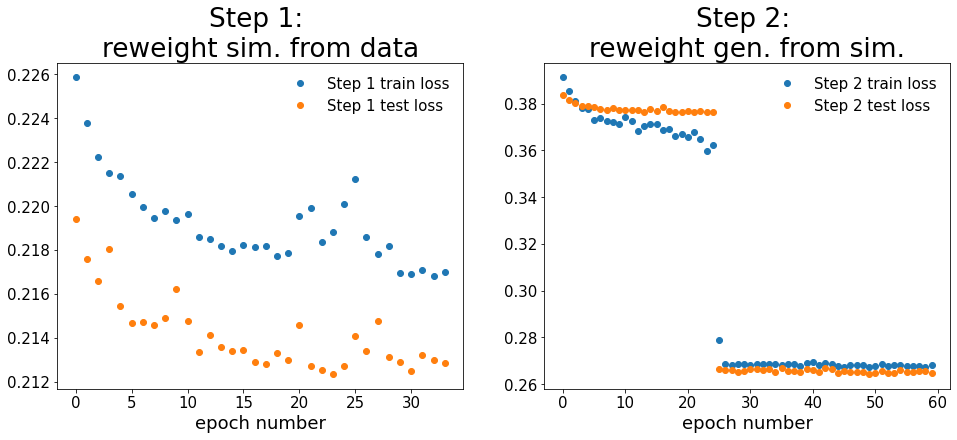

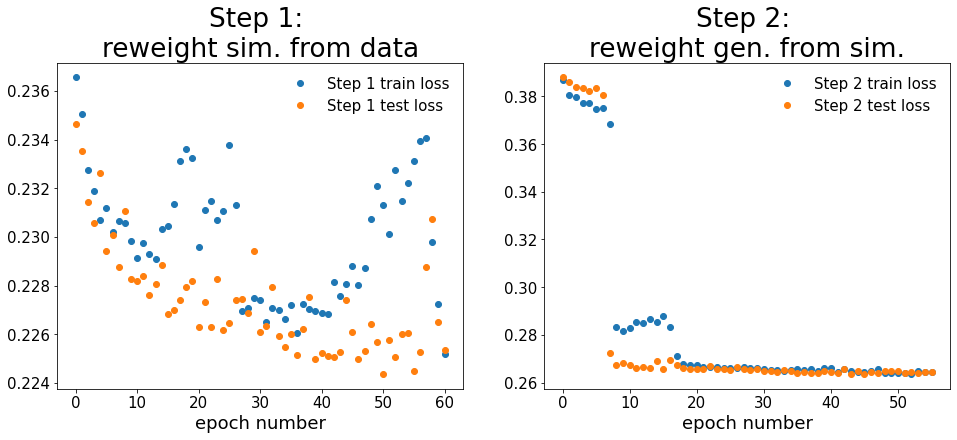

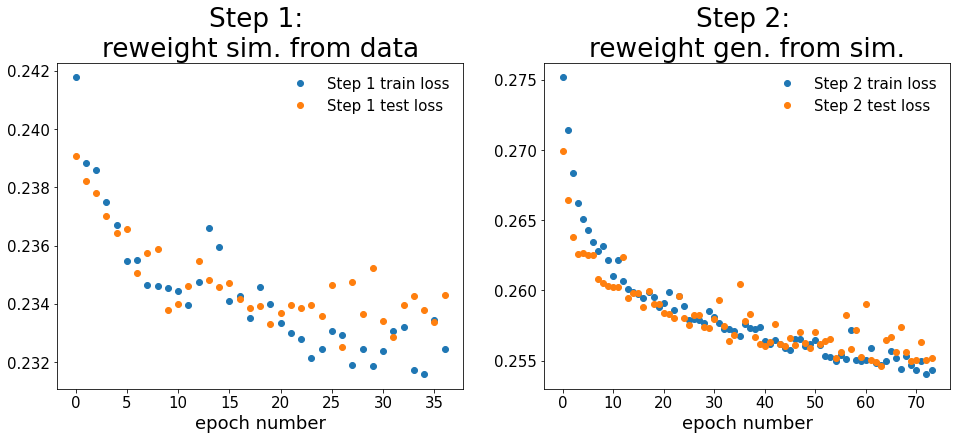

In [125]:
make_history_plots('C_pi_p')
make_history_plots('D_pi_p')

## Plot data and MC reweighted

In [126]:
## This is what in Ben's notebook. 
## The _S is RECO level. 
## You require that the RECO dataframe has a valid pass reco.
## The G is the truth level
## You required that the truth level has pass_truth valid.

In [127]:
#


def reweight_summary_plots(setname, showIter=False):
    df_data = dfs_data[setname].query("h1_pid*h2_pid<0")
    df_mc = dfs_mc[setname].query("h1_pid*h2_pid<0")
    for i in (len(weights[setname])-1,):
        pass_reco = df_mc.pass_reco != 0
        print(len(pass_reco))
        print("ITERATION: {}".format(i + 1))
        for df in df_data, df_mc:
            if not 'diff_phi_lab' in df.columns:
                df.eval('diff_phi_lab = (h1_ph-h2_ph)',inplace=True)
                df['diff_phi_lab'] = df.diff_phi_lab+(df.diff_phi_lab>180)*-360+(df.diff_phi_lab<-180)*360
        fig, ax = plt.subplots(3,
                               3,
                               figsize=(16, 16),
                               constrained_layout=True)
        #fig.suptitle(suptitles[setname])

        bins = [[np.linspace(0.0, 4.2, 40), np.linspace(0, 0.6, 50), np.linspace(-np.pi, np.pi, 50)],
               [np.linspace(0, 1, 50), np.linspace(0, 1.5, 50), np.linspace(-np.pi, np.pi, 50)],
               [np.linspace(0, 1, 50), np.linspace(0, 1.5, 50), np.linspace(0.3, 1.7, 50)]]
        xlabels = [[r'$Q^{2}$ [GeV$^2$]', r'$x$', r'$\Delta\phi_{\mathrm{lab}}$ [rad]'],
                  [r'$z_1$', r'$p^1_T$ [GeV]', r'$\Delta\phi$ [rad]'],
                  [r'$z_2$', r'$p^2_T$ [GeV]', r'$m_{\pi\pi}$ [GeV]']]
        xvars = [['Q2', 'x', f'diff_phi_lab*{np.pi}/180'],
                ['h1_z', 'h1_cm_pt','diff_phi_cm'],
                ['h2_z', 'h2_cm_pt','pair_mass']]

        for row in range(3):
            for col in range(3):

                ax[row,col].set_xlabel(xlabels[row][col])
                ax[row,col].set_ylabel('Events per bin (Normalized)')
                #ax[row,col].hist(df_mc[xvars[row][col]][pass_reco], bins=bins[row][col], label=r'MC .', **plot_style_2)
                #print(len(weights), len(weights[i,0,:]), len(pass_reco),len(df_data))

                ax[row,col].hist(df_mc[pass_reco].eval(xvars[row][col]),
                           bins=bins[row][col],
                           weights=weights[setname][i, 0, :][pass_reco],
                           label=r'MC',
                           **plot_style_2)

                #ax[row,col].hist(df_data[xvars[row][col]],
                #           bins=bins[row][col],
                #           label=r'Data (reco)',
                #           **plot_style_2)
                y,x = np.histogram(df_data.eval(xvars[row][col]),
                           bins=bins[row][col])
                
                denom = np.sum(y)*(x[1]-x[0])
                #print(y/denom)
                x = 0.5*(x[1:]+x[:-1])#bin centers
                ax[row,col].errorbar(x,y/denom,np.sqrt(y)/denom, color='k', label='Data (recon)')
                
                if row == 0 and col == 0:
                    ax[row,col].legend(frameon=False,loc='best')


        fig.savefig(f"images/reweight_summary_{setname}_iter{i}.png",bbox_inches='tight')

In [128]:

#reweight_summary_plots('C_pi_p')
#reweight_summary_plots('D_pi_p')

## Put weights obtained with the DNN back into the mc dataframe:

In [129]:
#help(root_pandas)

In [85]:
for a in "D C".split():
    df = dfs_mc[f'{a}_pi_p']#.query("weight_truth>0")
    w_default = np.mean(df.query("pass_recon==1").weight_truth)
    df['weight_truth']=df.eval(f"weight_truth*pass_reco+(pass_reco!=0)*{w_default}")

In [90]:
import pickle as pkl
for target in "D C".split():
    d = {target : dfs_mc[f'{target}_pi_p']}
    with open(f"MC_pion_proton_pairs_weighted_{target}.pkl", "wb") as f:
        pkl.dump(d,f)

In [132]:
#for key in weights.keys():
#    dfs_mc[key]['weight_reco'] = weights[key][-1, 0, :]
#    dfs_mc[key]['weight_truth'] = weights[key][-1, 1, :]
#    dfs_mc[key].to_root(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_{key}.root","dihadrons")

# slice plots

In [133]:
def slice_plot(key, xvar,xlabel, bins, slicevar, slicelabel, partitions,
               suptitle=None, sliceUnit=None, legend=False):
    df_mc =dfs_mc[key].query("h1_pid*h2_pid<0")
    df_data =dfs_data[key].query("h1_pid*h2_pid<0")
    fig, axs = plt.subplots(1, len(partitions)-1, 
                            figsize=(4*(len(partitions)-1), 4),sharex='all')
    fig.subplots_adjust(wspace=0)
    if suptitle is not None:
        fig.suptitle(suptitle, y=1.15)
    
    axs[0].set_ylabel('Events per bin (Normalized)')
    for i in range(len(partitions)-1):
        query = f'{slicevar}>{partitions[i]} and {slicevar}<{partitions[i+1]}'
        axs[i].set_xlabel(xlabel)
        title = f'{partitions[i]} <{slicelabel}<{partitions[i+1]}'
        if sliceUnit !=None:
            title += f'[{sliceUnit}]'
        axs[i].set_title(title,fontsize='medium')                 
        mc = df_mc.query(query).query("pass_reco != 0")
        #axs[i].hist(mc.eval(xvar), bins=bins, label=r'MC .', **plot_style_2)
        #print(len(weights), len(weights[i,0,:]), len(pass_reco),len(df_data))

        axs[i].hist(mc.eval(xvar),
                   bins=bins,
                   weights=mc.weight_reco,
                   label=r'MC',
                   **plot_style_2)

        #axs[i].hist(df_data.query(query).eval(xvar),
        #           bins=bins,
        #           label=r'Data (recon)',
        #           **plot_style_2)
        y,x = np.histogram(df_data.query(query).eval(xvar),
                           bins=bins)        
        denom = np.sum(y)*(x[1]-x[0])
        x = 0.5*(x[1:]+x[:-1])#bin centers
        axs[i].errorbar(x,y/denom,np.sqrt(y)/denom, color='k', label='Data (recon)')
        
        if i==0 and legend:
            axs[i].legend(frameon=False,loc='best')
    plt.savefig(f"images/reweight_eg2_slices_{slicevar}_vs_{xvar}_{key}.png",bbox_inches='tight')
        


In [134]:

for key in 'D_2pi'.split():
    #determine the suptitle to use
    suptitle = None #suptitles[key]
    
    #z1 slices, z2 bins
    slice_plot(key, 'h2_z', '$z_2$', np.linspace(0,.6 if '2pi' in key else .8, 20), 
               'h1_z', '$z_1$', (0.5, 0.6, 0.7, 0.8,1.0), suptitle=suptitle)
    #slice_plot(key, 'diff_phi_cm', r'$\Delta\phi_{cm}$ [rad]', np.linspace(-np.pi,np.pi, 20), 
    #       'diff_rap_cm', r'$\Delta y_{cm}$', (-0.5, 1.0, 2.0, 3.0), suptitle=suptitle)
    
    #z2 slices, diff_phi_cm
    slice_plot(key, 'diff_phi_cm', r'$\Delta\phi$ [rad]', np.linspace(-np.pi,np.pi, 20), 
           'h2_z', r'$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle,legend=True)
    #slice_plot(key, 'x', r'$x$', np.linspace(0.1, 0.6, 40), 
    #       'Q2', r'$Q^2$', (1.0, 2.0, 3.0, 4.0), suptitle=suptitle,sliceUnit='GeV$^2$')
    #slice_plot(key, 'h1_cm_pt', r'$p^1_T$', np.linspace(0, 1, 40), 
    #       'h2_cm_pt', r'$p^2_T$', (0, 0.3, 0.6, 0.9), suptitle=suptitle,sliceUnit='GeV')
    slice_plot(key, 'h1_z', '$z_1$', np.linspace(0.5,1, 20), 
               'h2_z', '$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle)
    
    slice_plot(key, 'h2_cm_pt', r'$p^2_T$ [GeV]', np.linspace(0, 1, 40), 
           'h2_z', r'$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle,sliceUnit=None)
    slice_plot(key, 'h1_cm_pt', r'$p^1_T$ [GeV]', np.linspace(0, 1, 40), 
           'h2_z', r'$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle,sliceUnit=None)
    
    slice_plot(key, 'pair_pt', r'$p^{\mathrm{pair}}_T$ [GeV]', np.linspace(0, 3, 40), 
           'h2_z', r'$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle,sliceUnit=None)
    
    slice_plot(key, f'h2_th*{np.pi/180}', r'$\theta^{\mathrm{lab}}_{h2}$ [rad]', np.linspace(0, 1.7, 40), 
           'h2_z', r'$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle,sliceUnit=None)

KeyError: 'D_2pi'

In [ ]:
print(dfs_mc['C_2pi'].columns)

(array([5255., 5035., 4603., 4231., 4053., 3901., 4102., 4224., 4141.,
        4267., 4244., 4381., 4383., 4765., 4996., 5151., 5253., 5091.,
        4524., 4022., 3523., 3348., 3101., 3014., 2817., 2760., 2601.,
        2577., 2526., 2643., 2724., 2913., 2978., 2861., 2727., 2504.,
        2096., 1912., 1751., 1600., 1619., 1517., 1504., 1479., 1525.,
        1561., 1704., 1859., 2049., 2127., 2205., 2025., 1878., 1736.,
        1572., 1619., 1435., 1619., 1517., 1555., 1663., 1780., 1882.,
        2062., 2406., 2761., 3023., 2953., 2895., 2831., 2584., 2533.,
        2591., 2635., 2766., 2862., 2992., 3199., 3329., 3637., 4019.,
        4563., 5088., 5286., 5272., 4862., 4637., 4486., 4454., 4199.,
        4269., 4245., 4146., 4172., 4045., 4190., 4445., 4734., 4963.,
        5271.]),
 array([-1.79999596e+02, -1.76399605e+02, -1.72799614e+02, -1.69199624e+02,
        -1.65599633e+02, -1.61999643e+02, -1.58399652e+02, -1.54799661e+02,
        -1.51199671e+02, -1.47599680e+02, -1.43999

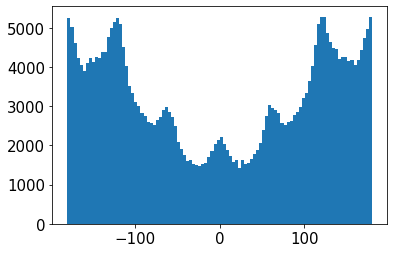

In [150]:
plt.hist(dfs_mc['D_2pi'].eval('h1_ph-h2_ph+360*(h1_ph-h2_ph<-180)-360*(h1_ph-h2_ph>180)'),bins=100)

/home/sebouh/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


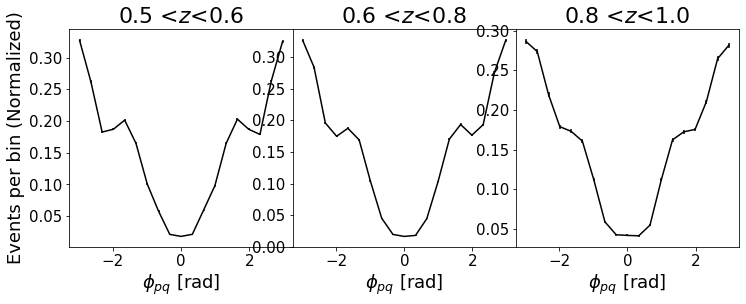

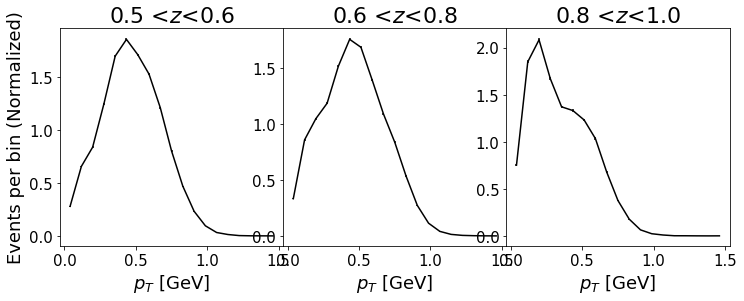

In [37]:
for key in 'D_trigger_cut'.split():
    #determine the suptitle to use
    suptitle = None #suptitles[key]
    
    slice_plot(key, 'h1_cm_ph', '$\\phi_{pq}$ [rad]', np.linspace(-np.pi,np.pi, 20), 
               'h1_z', '$z$', (0.5, 0.6, 0.8,1.0), suptitle=suptitle)
    
    slice_plot(key, 'h1_cm_pt', '$p_T$ [GeV]', np.linspace(0,1.5, 20), 
               'h1_z', '$z$', (0.5, 0.6, 0.8,1.0), suptitle=suptitle)

In [74]:
print(dfs_mc.keys())

dict_keys(['D_2pi', 'D_pi_p', 'D_trigger_cut', 'C_2pi', 'C_pi_p', 'C_trigger_cut'])


In [69]:
d = {}
for a in 'D C Fe Pb'.split():
    q = "dphi< 0.1"
    rd = len(dfs_data[a+"_2pi"].query(q))/len(dfs_data[a+"_trigger_cut"])
    rw = sum(dfs_mc[a+"_2pi"].query(q).weight_reco)/len(dfs_mc[a+"_trigger_cut"])
    d[a] = rd/rw
print({a:d[a]/d['D'] for a in 'C Fe Pb'.split()})

{'C': 1.2854192723717053, 'Fe': 1.0891773832191007, 'Pb': 1.0905072085165464}


In [66]:
print(len(dfs_all[f'MC_{a}_2pi'].query("h2_z>0")))
print(len(dfs_all[f'MC_{a}_2pi']))

62313
62313
